Importing Library

In [12]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression, HuberRegressor, LassoCV, RidgeCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression


Read data and filter it based on SICCD 4800 to 4899

In [8]:
# # Read the CSV from WRDS (estimation period)
# df = pd.read_csv("2000.csv") 

# # Convert the SICCD column to numeric
# df['SICCD'] = pd.to_numeric(df['SICCD'], errors='coerce')

# # Filter the DataFrame for SICCD in the range 4800 to 4899 (Communication)
# communication_df = df[(df['SICCD'] >= 4800) & (df['SICCD'] <= 4899)]

# # Result
# print(communication_df)
# communication_df.to_csv("communication_services_2000.csv", index=False)

In [9]:
# # Read the CSV file
# df = pd.read_csv("2016.csv") 

# # Convert the SICCD column to numeric, forcing errors to NaN (not a number)
# df['SICCD'] = pd.to_numeric(df['SICCD'], errors='coerce')

# # Filter the DataFrame for SICCD in the range 4800 to 4899
# communication_df = df[(df['SICCD'] >= 4800) & (df['SICCD'] <= 4899)]

# # Result
# print(communication_df)
# communication_df.to_csv("communication_services_2016.csv", index=False)

Checking Missing Data in Estimation Period

In [10]:
estimation_df = pd.read_csv("communication_services_2000.csv") 
outofsample_df = pd.read_csv("communication_services_2016.csv") 

estimation_df.head()
# Check for Missing Values
missing_data = estimation_df.isnull().sum()

# Calculate the percentage of missing data for each column
missing_percentage = (missing_data / len(estimation_df)) * 100

# Create a DataFrame to display the results
missing_info = pd.DataFrame({
    'Missing Values': missing_data,
    'Percentage of Missing Data (%)': missing_percentage
})
print(missing_info)


        Missing Values  Percentage of Missing Data (%)
PERMNO               0                        0.000000
date                 0                        0.000000
SICCD                0                        0.000000
COMNAM               0                        0.000000
PRC              17602                        2.052640
RET                816                        0.095157
SHROUT             417                        0.048628


C:\Users\fazlu\AppData\Local\Temp\ipykernel_8504\2277442323.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  outofsample_df = pd.read_csv("communication_services_2016.csv")


In [11]:
unique_permnos = estimation_df['PERMNO'].unique()

print("Count of all unique PERMNOs:")
print(len(unique_permnos))

# Filter rows with any missing values
rows_with_missing = estimation_df[estimation_df.isnull().any(axis=1)]

# Get unique PERMNOs from those rows
permnos_with_missing = rows_with_missing['PERMNO'].unique()

print("Count of PERMNOs with any missing data:")
print(len(permnos_with_missing))



Count of all unique PERMNOs:
605
Count of PERMNOs with any missing data:
387


In [12]:
# Step 1: Get all PERMNOs with any missing data
permnos_with_missing = estimation_df[estimation_df.isnull().any(axis=1)]['PERMNO'].unique()

# Step 2: Filter out those PERMNOs from the DataFrame
clean_df = estimation_df[~estimation_df['PERMNO'].isin(permnos_with_missing)]

# Optional: reset index
clean_df = clean_df.reset_index(drop=True)


In [13]:
unique_permnos = clean_df['PERMNO'].unique()

print("All unique PERMNOs after cleaning:")
print(len(unique_permnos))

All unique PERMNOs after cleaning:
218


In [14]:
clean_df.head()

,PERMNO,date,SICCD,COMNAM,PRC,RET,SHROUT
0,10066,2000-01-03,4813.0,FRANKLIN TELECOMMUNICATIONS CORP,2.5000,0.000000,28258.0
1,10066,2000-01-04,4813.0,FRANKLIN TELECOMMUNICATIONS CORP,2.3750,-0.050000,28258.0
2,10066,2000-01-05,4813.0,FRANKLIN TELECOMMUNICATIONS CORP,2.3750,0.000000,28258.0
3,10066,2000-01-06,4813.0,FRANKLIN TELECOMMUNICATIONS CORP,2.5000,0.052632,28258.0
4,10066,2000-01-07,4813.0,FRANKLIN TELECOMMUNICATIONS CORP,2.1875,-0.125000,28258.0


Checking full count of full trading days from 2000 to 2015 

In [15]:
trading_days_count = clean_df.groupby('PERMNO').size()
print(trading_days_count.max())

4025


We got the full count is 4025. So we will filter the data to only have 4025 data to ensure the trading has no missing data in estimation period.

In [16]:
# Daily market cap
clean_df['PRC'] = clean_df['PRC'].abs()
clean_df['MKT_CAP'] = clean_df['PRC'] * clean_df['SHROUT'] * 1000

days_minimum_count = trading_days_count.max()

# Filter for PERMNOs 
valid_permnos = trading_days_count[trading_days_count >= days_minimum_count].index
filtered_df = clean_df[clean_df['PERMNO'].isin(valid_permnos)].copy()

# Compute average market cap on the filtered data
avg_market_caps = (
    filtered_df.groupby('PERMNO')['MKT_CAP']
    .mean()
    .sort_values(ascending=False)
)

# Get top 50 PERMNOs by average market cap (after filtering)
top_50_permnos = avg_market_caps.head(50).index

# Filter to top 50 stocks for both estimation and out-of-sample data
top_50_df = filtered_df[filtered_df['PERMNO'].isin(top_50_permnos)].copy()
top_50_out_df = outofsample_df[outofsample_df['PERMNO'].isin(top_50_permnos)].copy()


In [17]:
french_2000_df = pd.read_csv("French2000.csv")
french_2000_df['date'] = pd.to_datetime(french_2000_df['date'])
french_2000_df['rf'] = pd.to_numeric(french_2000_df['rf'], errors='coerce')

top_50_df['date'] = pd.to_datetime(top_50_df['date'])
french_2000_df = french_2000_df.sort_values('date')
top_50_df = top_50_df.sort_values('date')

top_50_df = pd.merge_asof(
    top_50_df,
    french_2000_df[['date', 'rf']],
    left_on='date',
    right_on='date',
    direction='backward'
)

# Ensure RET is numeric
top_50_df['RET'] = pd.to_numeric(top_50_df['RET'], errors='coerce')

# Calculate EXCESS_RET
top_50_df['EXCESS_RET'] = top_50_df['RET'] - top_50_df['rf']

In [19]:
top_50_out_df['PRC'] = top_50_out_df['PRC'].abs()
top_50_out_df['MKT_CAP'] = top_50_out_df['PRC'] * top_50_out_df['SHROUT'] * 1000

french_2016_df = pd.read_csv("French2016.csv")
french_2016_df['date'] = pd.to_datetime(french_2016_df['date'])
french_2016_df['rf'] = pd.to_numeric(french_2016_df['rf'], errors='coerce')

top_50_out_df['date'] = pd.to_datetime(top_50_out_df['date'])
french_2016_df = french_2016_df.sort_values('date')
top_50_out_df = top_50_out_df.sort_values('date')

# Merge rf with top_50_out_df based on nearest previous date
top_50_out_df = pd.merge_asof(
    top_50_out_df,
    french_2016_df[['date', 'rf']],
    left_on='date',
    right_on='date',
    direction='backward'
)

# Ensure RET is numeric
top_50_out_df['RET'] = pd.to_numeric(top_50_out_df['RET'], errors='coerce')

# Calculate EXCESS_RET
top_50_out_df['EXCESS_RET'] = top_50_out_df['RET'] - top_50_out_df['rf']
display(top_50_out_df)

,PERMNO,date,SICCD,COMNAM,PRC,RET,SHROUT,MKT_CAP,rf,EXCESS_RET
0,11174,2016-01-04,4840.0,AMERICAS CAR MART INC,27.37,0.025478,8447.0,2.311944e+08,0.00000,0.025478
1,80924,2016-01-04,4832.0,SIRIUS X M HOLDINGS INC,3.95,-0.029484,5147647.0,2.033321e+10,0.00000,-0.029484
2,80863,2016-01-04,4813.0,NIPPON TELEGRAPH & TELPHONE CORP,39.17,-0.014343,65185.0,2.553296e+09,0.00000,-0.014343
3,80297,2016-01-04,4830.0,EMMIS COMMUNICATIONS CORP,0.65,0.015625,41340.0,2.687100e+07,0.00000,0.015625
4,66835,2016-01-04,4813.0,B T GROUP PLC,34.30,-0.008957,25600.0,8.780800e+08,0.00000,-0.008957
...,...,...,...,...,...,...,...,...,...,...
74514,86996,2024-12-31,4899.0,S B A COMMUNICATIONS CORP NEW,203.80,0.002361,107523.0,2.191319e+10,0.00017,0.002191
74515,86916,2024-12-31,4832.0,URBAN ONE INC,1.54,0.003257,8180.0,1.259720e+07,0.00017,0.003087
74516,66093,2024-12-31,4812.0,A T & T INC,22.77,0.007077,7175289.0,1.633813e+11,0.00017,0.006907
74517,80924,2024-12-31,4832.0,SIRIUS X M HOLDINGS INC NEW,22.80,0.000000,339202.0,7.733806e+09,0.00017,-0.000170


Calculate EXCESS_RET using French data 

In [20]:
display(top_50_df.head())
display(top_50_out_df.head())

,PERMNO,date,SICCD,COMNAM,PRC,RET,SHROUT,MKT_CAP,rf,EXCESS_RET
0,11174,2000-01-03,4840.0,CROWN GROUP INC,5.10938,0.034810,9711.0,4.961719e+07,0.00021,0.034600
1,80924,2000-01-03,4830.0,SIRIUS SATELLITE RADIO INC,41.12500,-0.075843,28721.0,1.181151e+09,0.00021,-0.076053
2,83604,2000-01-03,4812.0,S K TELECOM CO LTD,38.75000,0.009772,123912.0,4.801590e+09,0.00021,0.009562
3,80297,2000-01-03,4830.0,EMMIS COMMUNICATIONS CORP,113.75000,-0.087376,13418.0,1.526298e+09,0.00021,-0.087586
4,85421,2000-01-03,4812.0,CHINA TELECOM HONG KONG,139.00000,0.080661,5009.0,6.962510e+08,0.00021,0.080451


,PERMNO,date,SICCD,COMNAM,PRC,RET,SHROUT,MKT_CAP,rf,EXCESS_RET
0,11174,2016-01-04,4840.0,AMERICAS CAR MART INC,27.37,0.025478,8447.0,2.311944e+08,0.0,0.025478
1,80924,2016-01-04,4832.0,SIRIUS X M HOLDINGS INC,3.95,-0.029484,5147647.0,2.033321e+10,0.0,-0.029484
2,80863,2016-01-04,4813.0,NIPPON TELEGRAPH & TELPHONE CORP,39.17,-0.014343,65185.0,2.553296e+09,0.0,-0.014343
3,80297,2016-01-04,4830.0,EMMIS COMMUNICATIONS CORP,0.65,0.015625,41340.0,2.687100e+07,0.0,0.015625
4,66835,2016-01-04,4813.0,B T GROUP PLC,34.30,-0.008957,25600.0,8.780800e+08,0.0,-0.008957


Generate Descriptive Statistic for estimation period

In [ ]:
# Descriptive stats for excess return
descriptive_stats = (
    top_50_df.groupby('PERMNO')['EXCESS_RET']
    .agg(['mean', 'std', 'min', 'max', 'count'])
    .reset_index()
)

# Add average market cap to the summary
avg_market_caps_df = avg_market_caps.reset_index(name='avg_market_cap')
descriptive_stats = descriptive_stats.merge(avg_market_caps_df, on='PERMNO')

# Final sort
descriptive_stats = descriptive_stats.sort_values(by='avg_market_cap', ascending=False)

# Show results
display(descriptive_stats)


,PERMNO,mean,std,min,max,count,avg_market_cap
6,66093,0.000180,0.016982,-0.126862,0.162761,4025,1.525590e+11
12,76226,0.000347,0.026495,-0.207582,0.265798,4025,3.595443e+10
2,29647,0.000407,0.017042,-0.340483,0.201300,4025,2.612402e+10
13,78405,0.000475,0.020393,-0.103351,0.184337,4025,1.118552e+10
32,86339,0.000712,0.032299,-0.388358,0.312135,4025,1.055480e+10
23,81696,0.000493,0.029007,-0.191503,0.246158,4025,7.598406e+09
14,78840,0.000457,0.024231,-0.200440,0.164129,4025,7.298852e+09
20,80924,0.000722,0.053497,-0.517130,0.894677,4025,7.227508e+09
17,80089,0.000381,0.023121,-0.147669,0.232170,4025,6.774852e+09
29,85991,0.000181,0.045367,-0.394349,0.508580,4025,6.437152e+09


In [ ]:
# Descriptive stats for excess return
descriptive_stats_out = (
    top_50_out_df.groupby('PERMNO')['EXCESS_RET']
    .agg(['mean', 'std', 'min', 'max', 'count'])
    .reset_index()
)
avg_market_caps_out = (
    top_50_out_df.groupby('PERMNO')['MKT_CAP']
    .mean()
    .sort_values(ascending=False)
)
# Add average market cap to the summary
avg_market_caps_out_df = avg_market_caps_out.reset_index(name='avg_market_cap_out')
descriptive_stats_out = descriptive_stats_out.merge(avg_market_caps_out_df, on='PERMNO')

# Final sort
descriptive_stats_out = descriptive_stats_out.sort_values(by='avg_market_cap_out', ascending=False)

# Show results
display(descriptive_stats_out)


,PERMNO,mean,std,min,max,count,avg_market_cap_out
6,66093,0.000212,0.014675,-0.104241,0.100163,2264,1.971695e+11
32,86339,0.000858,0.015879,-0.124310,0.113335,1261,4.883149e+10
2,29647,0.000006,0.011717,-0.127195,0.121471,2264,3.969163e+10
36,86996,0.000399,0.017509,-0.089386,0.124232,2264,2.479350e+10
20,80924,0.000001,0.023239,-0.152762,0.422367,2264,2.296622e+10
29,85991,0.000081,0.016062,-0.094118,0.105489,462,1.945408e+10
13,78405,0.000107,0.014108,-0.142199,0.132176,2264,1.835935e+10
12,76226,-0.000194,0.030029,-0.283690,0.307564,2264,1.727642e+10
31,86218,0.000569,0.016962,-0.147470,0.413667,1825,1.057748e+10
14,78840,0.000763,0.024859,-0.177746,0.208441,2264,9.613821e+09


In [23]:
def add_rolling_features(df, window):
    df = df.sort_values(['PERMNO', 'date']).copy()
    
    # Rolling mean of past EXCESS_RET 
    df[f'rolling_mean_excess_ret_window'] = (
        df.groupby('PERMNO')['EXCESS_RET']
        .transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).mean())
    )
    df = df.dropna()
    return df

In [24]:
# Changeable window
window_sizes = 5

top_50_df = add_rolling_features(top_50_df, window_sizes)
top_50_out_df = add_rolling_features(top_50_out_df, window_sizes)


In [25]:
display(top_50_df)

,PERMNO,date,SICCD,COMNAM,PRC,RET,SHROUT,MKT_CAP,rf,EXCESS_RET,rolling_mean_excess_ret_window
57,11174,2000-01-04,4840.0,CROWN GROUP INC,5.0000,-0.021407,9711.0,48555000.0,0.00021,-0.021617,0.034600
94,11174,2000-01-05,4840.0,CROWN GROUP INC,4.8750,-0.025000,9711.0,47341125.0,0.00021,-0.025210,0.006492
142,11174,2000-01-06,4840.0,CROWN GROUP INC,5.1875,0.064103,9711.0,50375812.5,0.00021,0.063893,-0.004076
213,11174,2000-01-07,4840.0,CROWN GROUP INC,4.7500,-0.084337,9711.0,46127250.0,0.00021,-0.084547,0.012916
257,11174,2000-01-10,4840.0,CROWN GROUP INC,4.8750,0.026316,9711.0,47341125.0,0.00021,0.026106,-0.006576
...,...,...,...,...,...,...,...,...,...,...,...
172875,87373,2015-12-24,4813.0,ALASKA COMMUNICATIONS SYS GRP IN,1.7700,0.005682,50415.0,89234550.0,0.00000,0.005682,0.002357
172905,87373,2015-12-28,4813.0,ALASKA COMMUNICATIONS SYS GRP IN,1.7500,-0.011299,50415.0,88226250.0,0.00000,-0.011299,0.000046
172977,87373,2015-12-29,4813.0,ALASKA COMMUNICATIONS SYS GRP IN,1.7300,-0.011429,50415.0,87217950.0,0.00000,-0.011429,0.000046
173014,87373,2015-12-30,4813.0,ALASKA COMMUNICATIONS SYS GRP IN,1.7600,0.017341,50415.0,88730400.0,0.00000,0.017341,0.000046


In [26]:
top_50_df.to_csv("top50_estimation.csv", index=False)
top_50_out_df.to_csv("top50_outofsample.csv",index=False)

In [6]:
top_50_df = pd.read_csv("top50_estimation.csv") 
top_50_out_df = pd.read_csv("top50_outofsample.csv") 

top_50_df['date'] = pd.to_datetime(top_50_df['date'])
top_50_out_df['date'] = pd.to_datetime(top_50_out_df['date'])

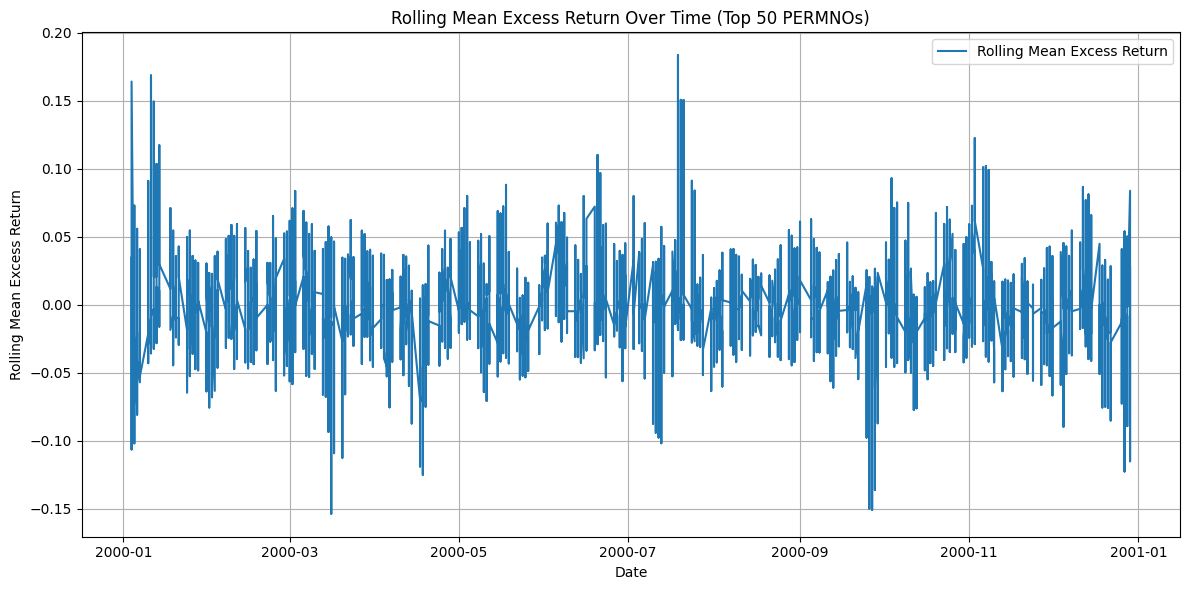

In [7]:
import matplotlib.pyplot as plt

# Make sure 'date' is in datetime format

# Sort by date
top_50_df = top_50_df.sort_values('date')
df_2000 = top_50_df[top_50_df['date'].dt.year == 2000]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_2000['date'], df_2000['rolling_mean_excess_ret_window'], label='Rolling Mean Excess Return')
plt.xlabel('Date')
plt.ylabel('Rolling Mean Excess Return')
plt.title('Rolling Mean Excess Return Over Time (Top 50 PERMNOs)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

# # Parameters
# LAGS = 5
# TARGET = 'EXCESS_RET'
# ROLLING_FEATURE = 'rolling_mean_excess_ret_window'

# results = []

# # Function to create lagged features for a stock
# def create_lags(df, lags=5, target='EXCESS_RET'):
#     df = df.sort_values(by='date')
#     for lag in range(1, lags + 1):
#         df[f'{target}_lag_{lag}'] = df[target].shift(lag)
#     return df

# # Process each stock
# for permno in top_50_df['PERMNO'].unique():
#     # Filter stock-specific data
#     train_stock = top_50_df[top_50_df['PERMNO'] == permno].copy()
#     test_stock = top_50_out_df[top_50_out_df['PERMNO'] == permno].copy()
    
#     if train_stock.empty or test_stock.empty:
#         continue

#     # Add lagged features
#     train_stock = create_lags(train_stock, LAGS, TARGET)
#     train_stock = train_stock.dropna()

#     # Build lag features in test set using last few rows from training
#     last_train_rows = train_stock.sort_values(by='date').tail(LAGS)
#     for i, row in test_stock.iterrows():
#         for lag in range(1, LAGS + 1):
#             lag_val = last_train_rows.iloc[-lag][TARGET] if len(last_train_rows) >= lag else np.nan
#             test_stock.at[i, f'{TARGET}_lag_{lag}'] = lag_val

#     test_stock = test_stock.dropna()

#     features = [f'{TARGET}_lag_{i}' for i in range(1, LAGS + 1)] + [ROLLING_FEATURE]

#     X_train = train_stock[features]
#     y_train = train_stock[TARGET]
#     X_test = test_stock[features]
#     y_test = test_stock[TARGET]

#     if X_train.empty or X_test.empty:
#         continue

#     # Lasso
#     lasso = LassoCV(cv=3).fit(X_train, y_train)
#     lasso_pred = lasso.predict(X_test)

#     r2_lasso = r2_score(y_test, lasso_pred)
#     mse_lasso = mean_squared_error(y_test, lasso_pred)
#     mae_lasso = mean_absolute_error(y_test, lasso_pred)

#     results.append({
#         'PERMNO': permno,
#         'Model': 'Lasso',
#         'Window': window_sizes,
#         'R2': r2_lasso,
#         'MSE': mse_lasso,
#         'MAE': mae_lasso
#     })

#     # Ridge
#     ridge = RidgeCV(cv=3).fit(X_train, y_train)
#     ridge_pred = ridge.predict(X_test)

#     r2_ridge = r2_score(y_test, ridge_pred)
#     mse_ridge = mean_squared_error(y_test, ridge_pred)
#     mae_ridge = mean_absolute_error(y_test, ridge_pred)

#     results.append({
#         'PERMNO': permno,
#         'Model': 'Ridge',
#         'Window': window_sizes,
#         'R2': r2_ridge,
#         'MSE': mse_ridge,
#         'MAE': mae_ridge
#     })

# # Combine all results
# result_df = pd.DataFrame(results)

In [8]:
LAGS = 5
TARGET = 'EXCESS_RET'
ROLLING_FEATURE = 'rolling_mean_excess_ret_window'
features = [f'{TARGET}_lag_{i}' for i in range(1, LAGS + 1)] + [ROLLING_FEATURE]

# Step 1: Add lag features within each stock
def create_lags_per_stock(df, lags=5, target='EXCESS_RET'):
    df = df.sort_values(by=['PERMNO', 'date'])
    df_lagged = df.copy()
    for lag in range(1, lags + 1):
        df_lagged[f'{target}_lag_{lag}'] = df.groupby('PERMNO')[target].shift(lag)
    return df_lagged.dropna()

def directional_accuracy(y_true, y_pred):
    actual_diff = y_true.values[1:] - y_true.values[:-1]
    predicted_diff = y_pred[1:] - y_pred[:-1]
    correct = (actual_diff * predicted_diff > 0).sum()
    return correct / len(actual_diff)


train_lagged = create_lags_per_stock(top_50_df, LAGS, TARGET)
test_lagged = create_lags_per_stock(top_50_out_df, LAGS, TARGET)

# Step 2: Define train/test sets
X_train = train_lagged[features]
y_train = train_lagged[TARGET]
X_test = test_lagged[features]
y_test = test_lagged[TARGET]


In [9]:

# Step 3: Fit Lasso
lasso = LassoCV(cv=3).fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)

# Step 4: Fit Ridge
ridge = RidgeCV(cv=3).fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

# Step 5: Evaluation
results = []
results.append({
    'Model': 'Lasso',
    'Window': LAGS,
    'R2': r2_score(y_test, lasso_pred),
    'MSE': mean_squared_error(y_test, lasso_pred),
    'MAE': mean_absolute_error(y_test, lasso_pred),
    'Directional Accuracy': directional_accuracy(y_test, lasso_pred)
})

results.append({
    'Model': 'Ridge',
    'Window': LAGS,
    'R2': r2_score(y_test, ridge_pred),
    'MSE': mean_squared_error(y_test, ridge_pred),
    'MAE': mean_absolute_error(y_test, ridge_pred),
    'Directional Accuracy': directional_accuracy(y_test, ridge_pred)
})

result_df = pd.DataFrame(results)


In [10]:
display(result_df)

,Model,Window,R2,MSE,MAE,Directional Accuracy
0,Lasso,5,-0.002279,0.001158,0.017680,0.662968
1,Ridge,5,-0.003828,0.001159,0.017685,0.639614


In [15]:
results_linear = []

# 1. OLS
ols = LinearRegression().fit(X_train, y_train)
ols_pred = ols.predict(X_test)
results_linear.append({
    'Model': 'OLS',
    'R2': r2_score(y_test, ols_pred),
    'MSE': mean_squared_error(y_test, ols_pred),
    'MAE': mean_absolute_error(y_test, ols_pred),
    'Directional Accuracy': directional_accuracy(y_test, ols_pred)
})

# 2. Huber Regressor
huber = HuberRegressor().fit(X_train, y_train)
huber_pred = huber.predict(X_test)
results_linear.append({
    'Model': 'Robust OLS (Huber)',
    'R2': r2_score(y_test, huber_pred),
    'MSE': mean_squared_error(y_test, huber_pred),
    'MAE': mean_absolute_error(y_test, huber_pred),
    'Directional Accuracy': directional_accuracy(y_test, huber_pred)
})

# 3. PCR
pca = PCA(n_components=min(X_train.shape[1], 5))
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
pcr = LinearRegression().fit(X_train_pca, y_train)
pcr_pred = pcr.predict(X_test_pca)
results_linear.append({
    'Model': 'PCR',
    'R2': r2_score(y_test, pcr_pred),
    'MSE': mean_squared_error(y_test, pcr_pred),
    'MAE': mean_absolute_error(y_test, pcr_pred),
    'Directional Accuracy': directional_accuracy(y_test, pcr_pred)
})

# 4. PLS
pls = PLSRegression(n_components=min(X_train.shape[1], 5)).fit(X_train, y_train)
pls_pred = pls.predict(X_test).ravel()
results_linear.append({
    'Model': 'PLS',
    'R2': r2_score(y_test, pls_pred),
    'MSE': mean_squared_error(y_test, pls_pred),
    'MAE': mean_absolute_error(y_test, pls_pred),
    'Directional Accuracy': directional_accuracy(y_test, pls_pred)
})


# Display result table
result_df = pd.DataFrame(results_linear)


In [16]:
display(result_df)

,Model,R2,MSE,MAE,Directional Accuracy
0,OLS,-0.004040,0.00116,0.017686,0.639641
1,Robust OLS (Huber),-0.004552,0.00116,0.017680,0.676247
2,PCR,-0.004040,0.00116,0.017686,0.639641
3,PLS,-0.004040,0.00116,0.017686,0.639641


In [18]:
lasso_df = result_df[result_df['Model'] == 'Lasso']
display(lasso_df)

ridge_df = result_df[result_df['Model'] == 'Ridge']
display(ridge_df)

,Model,R2,MSE,MAE,Directional Accuracy


,Model,R2,MSE,MAE,Directional Accuracy


In [19]:
import torch
print(torch.cuda.is_available()) 

False


In [86]:
permno = top_50_out_df['PERMNO'].unique()[0]  # pick one stock to start
stock_data = pd.concat([
    top_50_df[top_50_df['PERMNO'] == permno],
    top_50_out_df[top_50_out_df['PERMNO'] == permno]
]).sort_values('date')

display(stock_data)
# Get the target series as a float32 NumPy array
series = stock_data[TARGET].dropna().values.astype("float32")


,PERMNO,date,SICCD,COMNAM,PRC,RET,SHROUT,MKT_CAP,rf,EXCESS_RET,rolling_mean_excess_ret_window
57,11174,2000-01-04,4840.0,CROWN GROUP INC,5.0000,-0.021407,9711.0,48555000.0,0.00021,-0.021617,0.034600
94,11174,2000-01-05,4840.0,CROWN GROUP INC,4.8750,-0.025000,9711.0,47341125.0,0.00021,-0.025210,0.006492
142,11174,2000-01-06,4840.0,CROWN GROUP INC,5.1875,0.064103,9711.0,50375812.5,0.00021,0.063893,-0.004076
213,11174,2000-01-07,4840.0,CROWN GROUP INC,4.7500,-0.084337,9711.0,46127250.0,0.00021,-0.084547,0.012916
257,11174,2000-01-10,4840.0,CROWN GROUP INC,4.8750,0.026316,9711.0,47341125.0,0.00021,0.026106,-0.006576
...,...,...,...,...,...,...,...,...,...,...,...
74417,11174,2024-12-24,4840.0,AMERICAS CAR MART INC,53.1300,-0.003002,8253.0,438481890.0,0.00017,-0.003172,-0.009873
74436,11174,2024-12-26,4840.0,AMERICAS CAR MART INC,53.6800,0.010352,8253.0,443021040.0,0.00017,0.010182,-0.008117
74462,11174,2024-12-27,4840.0,AMERICAS CAR MART INC,52.3100,-0.025522,8253.0,431714430.0,0.00017,-0.025692,0.003563
74477,11174,2024-12-30,4840.0,AMERICAS CAR MART INC,51.1500,-0.022175,8253.0,422140950.0,0.00017,-0.022345,-0.004919


In [59]:
import torch

prediction_length = 12  # or len(test_lagged[test_lagged['PERMNO'] == permno])
context = torch.tensor(series[:-prediction_length])
true_future = series[-prediction_length:]


In [60]:
from chronos import BaseChronosPipeline

pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",  # or "cuda" if supported
    torch_dtype=torch.float32,
)

quantiles, mean = pipeline.predict_quantiles(
    context=context,
    prediction_length=prediction_length,
    quantile_levels=[0.1, 0.5, 0.9]
)

In [61]:
from sklearn.metrics import r2_score, mean_squared_error

mean_np = mean.numpy().flatten()
print("R2:", r2_score(true_future, mean_np))
print("MSE:", mean_squared_error(true_future, mean_np))


R2: -0.059309959411621094
MSE: 0.0003344649157952517


R2 Score: -0.080
MSE: 0.0003


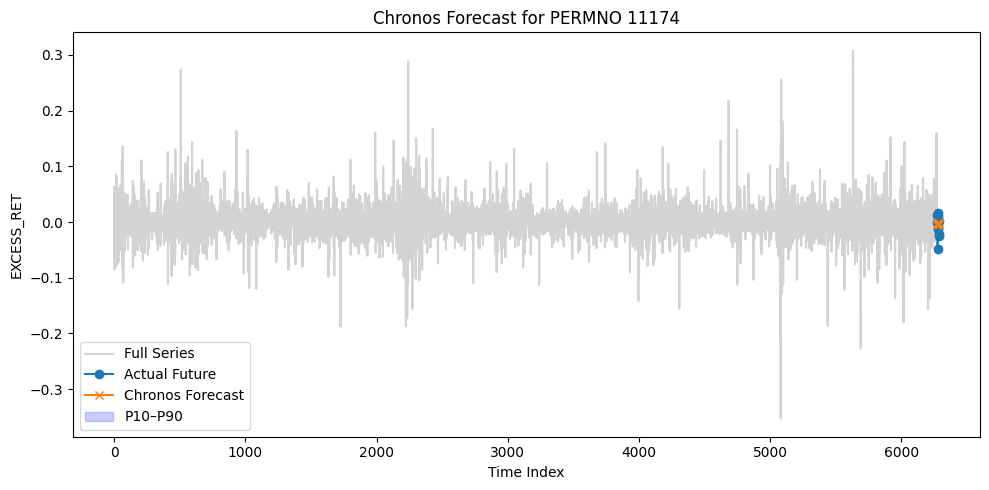

In [62]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from chronos import BaseChronosPipeline

# Settings
TARGET = 'EXCESS_RET'
prediction_length = 12

# Pick one stock to evaluate
permno = top_50_out_df['PERMNO'].unique()[0]
stock_data = pd.concat([
    top_50_df[top_50_df['PERMNO'] == permno],
    top_50_out_df[top_50_out_df['PERMNO'] == permno]
]).sort_values('date')

# Prepare full series
series = stock_data[TARGET].dropna().values.astype("float32")
context = torch.tensor(series[:-prediction_length])
true_future = series[-prediction_length:]

# Load Chronos model
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",
    torch_dtype=torch.float32,
)

# Predict
quantiles, mean = pipeline.predict_quantiles(
    context=context,
    prediction_length=prediction_length,
    quantile_levels=[0.1, 0.5, 0.9]
)

# Convert predictions
mean_np = mean.numpy().flatten()
q10 = quantiles[0, :, 0].numpy()
q90 = quantiles[0, :, 2].numpy()

# Evaluate
r2 = r2_score(true_future, mean_np)
mse = mean_squared_error(true_future, mean_np)

print(f"R2 Score: {r2:.3f}")
print(f"MSE: {mse:.4f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(range(len(series)), series, label="Full Series", color='lightgray')
plt.plot(range(len(series) - prediction_length, len(series)), true_future, label="Actual Future", marker='o')
plt.plot(range(len(series) - prediction_length, len(series)), mean_np, label="Chronos Forecast", marker='x')

# Add uncertainty bands
plt.fill_between(range(len(series) - prediction_length, len(series)), q10, q90, color='blue', alpha=0.2, label='P10–P90')

plt.title(f"Chronos Forecast for PERMNO {permno}")
plt.xlabel("Time Index")
plt.ylabel(TARGET)
plt.legend()
plt.tight_layout()
plt.show()


In [68]:
import pandas as pd
import torch
from sklearn.metrics import r2_score, mean_squared_error
from chronos import BaseChronosPipeline
import matplotlib.pyplot as plt

# Settings
TARGET = 'EXCESS_RET'
prediction_length = 12
results = []

# Load model once
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",
    torch_dtype=torch.float32,
)

# Loop through all stocks
for permno in top_50_out_df['PERMNO'].unique():
    try:
        # Combine train and test for this stock
        stock_data = pd.concat([
            top_50_df[top_50_df['PERMNO'] == permno],
            top_50_out_df[top_50_out_df['PERMNO'] == permno]
        ]).sort_values('date')

        # Drop NA and get series
        series = stock_data[TARGET].dropna().values.astype("float32")
        if len(series) <= prediction_length + 10:
            continue  # skip very short series

        context = torch.tensor(series[:-prediction_length])
        true_future = series[-prediction_length:]

        # Predict
        quantiles, mean = pipeline.predict_quantiles(
            context=context,
            prediction_length=prediction_length,
            quantile_levels=[0.1, 0.5, 0.9]
        )
        mean_np = mean.numpy().flatten()

        # Directional Accuracy
        def directional_accuracy(y_true, y_pred):
            actual_diff = y_true[1:] - y_true[:-1]
            predicted_diff = y_pred[1:] - y_pred[:-1]
            correct = (actual_diff * predicted_diff > 0).sum()
            return correct / len(actual_diff)

        # Store results
        results.append({
            'PERMNO': permno,
            'R2': r2_score(true_future, mean_np),
            'MSE': mean_squared_error(true_future, mean_np),
            'Directional Accuracy': directional_accuracy(true_future, mean_np)
        })

    except Exception as e:
        print(f"Skipped PERMNO {permno} due to error: {e}")

# Convert to DataFrame
results_df = pd.DataFrame(results)


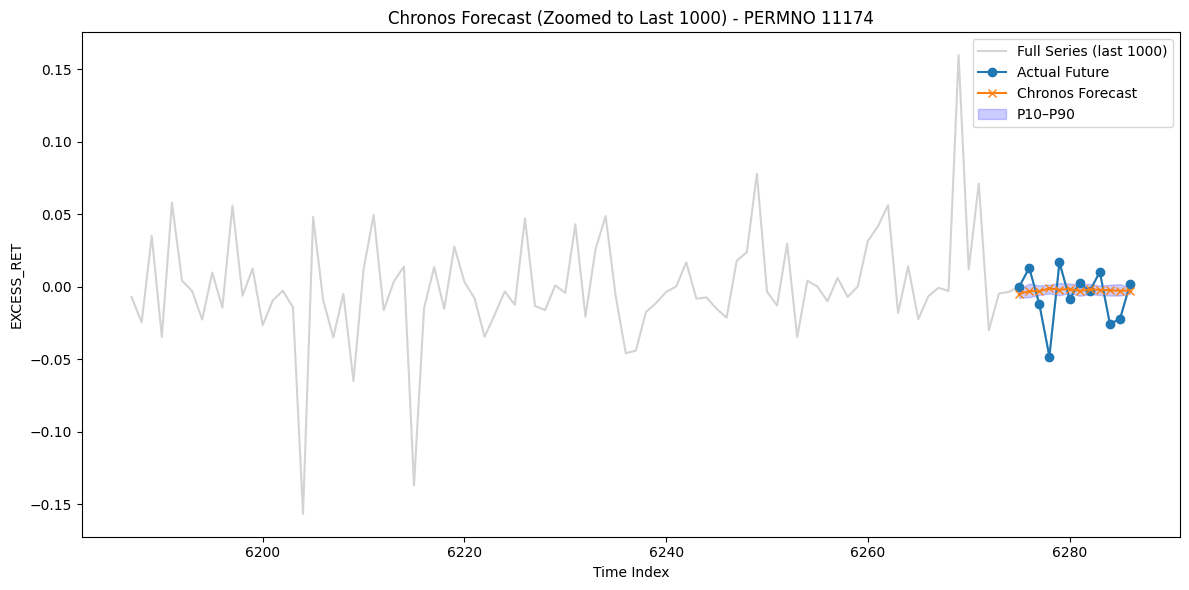

In [66]:
# Zoom range
zoom_start = max(0, len(series) - 100)
zoom_end = len(series)
zoom_x = range(zoom_start, zoom_end)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(zoom_x, series[zoom_start:], label="Full Series (last 1000)", color='lightgray')
plt.plot(zoom_x[-prediction_length:], true_future, label="Actual Future", marker='o')
plt.plot(zoom_x[-prediction_length:], mean_np, label="Chronos Forecast", marker='x')
plt.fill_between(zoom_x[-prediction_length:], q10, q90, color='blue', alpha=0.2, label='P10–P90')

plt.title(f"Chronos Forecast (Zoomed to Last 1000) - PERMNO {permno}")
plt.xlabel("Time Index")
plt.ylabel(TARGET)
plt.legend()
plt.tight_layout()
plt.show()


In [70]:
import pandas as pd
import torch
from sklearn.metrics import r2_score, mean_squared_error
from chronos import BaseChronosPipeline
import matplotlib.pyplot as plt

# Settings
TARGET = 'EXCESS_RET'
prediction_length = 12
results = []

# Load model once
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",
    torch_dtype=torch.float32,
)

# Loop through all stocks
for permno in top_50_out_df['PERMNO'].unique():
    try:
        # Combine train and test for this stock
        stock_data = pd.concat([
            top_50_df[top_50_df['PERMNO'] == permno],
            top_50_out_df[top_50_out_df['PERMNO'] == permno]
        ]).sort_values('date')

        # Drop NA and get series
        series = stock_data[TARGET].dropna().values.astype("float32")
        if len(series) <= prediction_length + 10:
            continue  # skip very short series

        context = torch.tensor(series[:-prediction_length])
        true_future = series[-prediction_length:]

        # Predict
        quantiles, mean = pipeline.predict_quantiles(
            context=context,
            prediction_length=prediction_length,
            quantile_levels=[0.1, 0.5, 0.9]
        )
        mean_np = mean.numpy().flatten()

        # Directional Accuracy
        def directional_accuracy(y_true, y_pred):
            actual_diff = y_true[1:] - y_true[:-1]
            predicted_diff = y_pred[1:] - y_pred[:-1]
            correct = (actual_diff * predicted_diff > 0).sum()
            return correct / len(actual_diff)

        # Store results
        results.append({
            'PERMNO': permno,
            'R2': r2_score(true_future, mean_np),
            'MSE': mean_squared_error(true_future, mean_np),
            'Directional Accuracy': directional_accuracy(true_future, mean_np)
        })

    except Exception as e:
        print(f"Skipped PERMNO {permno} due to error: {e}")

# Convert to DataFrame
results_df_chronos = pd.DataFrame(results)


In [73]:
display(results_df_chronos)

,PERMNO,R2,MSE,Directional Accuracy
0,11174,-0.053630,3.326715e-04,0.727273
1,12173,-0.407296,2.378509e-04,0.909091
2,29647,-0.171404,2.488589e-04,0.272727
3,39731,-0.018435,2.030246e-03,0.454545
4,47677,-1.881190,6.927465e-07,0.272727
5,63773,-0.031350,2.625359e-04,0.272727
6,66093,-0.104544,1.604454e-04,0.454545
7,66835,-0.416752,1.537397e-04,0.545455
8,68857,-0.098017,2.011293e-06,0.545455
9,75049,-0.149648,1.181070e-03,0.636364


In [ ]:
# Example: Use one PERMNO
permno = top_50_df['PERMNO'].iloc[0]
df_stock = pd.concat([
    top_50_df[top_50_df['PERMNO'] == permno],
    top_50_out_df[top_50_out_df['PERMNO'] == permno]
]).sort_values("date")

# Create TimesFM format: 'unique_id', 'ds', 'y'
df_input = pd.DataFrame({
    "unique_id": permno,
    "ds": pd.to_datetime(df_stock["date"]),
    "y": df_stock["EXCESS_RET"].astype('float32')
})

model = timesfm.TimesFm(
    hparams=timesfm.TimesFmHparams(
        backend="cpu",  # use "gpu" if available
        per_core_batch_size=1,
        horizon_len=12,  # how many steps ahead to predict
        input_patch_len=32,
        output_patch_len=128,
        num_layers=50,
        model_dims=1280,
        use_positional_embedding=False
    ),
    checkpoint=timesfm.TimesFmCheckpoint(
        huggingface_repo_id="google/timesfm-2.0-500m-pytorch"
    )
)


forecast_df = model.forecast_on_df(
    inputs=df_input,
    freq="D",          # use "M" or "B" for monthly/business if needed
    value_name="y",
    num_jobs=-1
)


Fetching 5 files: 100%|██████████| 5/5 [00:00<?, ?it/s]


Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
   unique_id         ds   timesfm  timesfm-q-0.1  timesfm-q-0.2  \
0      11174 2025-01-01  0.000173      -0.034782      -0.021628   
1      11174 2025-01-02 -0.000025      -0.036699      -0.022685   
2      11174 2025-01-03  0.001719      -0.036125      -0.021330   
3      11174 2025-01-04  0.001379      -0.037057      -0.022109   
4      11174 2025-01-05 -0.002444      -0.041220      -0.026212   

   timesfm-q-0.3  timesfm-q-0.4  timesfm-q-0.5  timesfm-q-0.6  timesfm-q-0.7  \
0      -0.012646      -0.005893       0.000173       0.006419       0.013833   
1      -0.013322      -0.006233      -0.000025       0.006482       0.014041   
2      -0.011894      -0.004437       0.001719       0.008471       0.016161   
3      -0.012358      -0.005019       0.001379       0.008083       0.015785   
4      -0.016337      -0.008896      -0.002444       0.004271       0.012000   

   timesfm-q-0

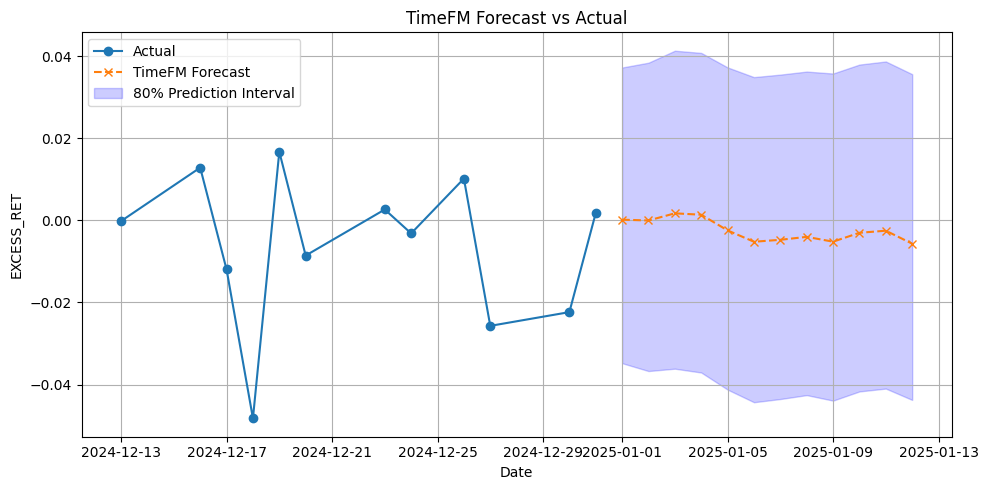

In [89]:

# Number of steps predicted
h = len(forecast_df)

# Get actual last values for comparison
true_future = df_input['y'].values[-h:]
actual_dates = df_input['ds'].values[-h:]

# Predicted values
predicted_values = forecast_df['timesfm'].values
predicted_dates = forecast_df['ds'].values

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Actual values
plt.plot(actual_dates, true_future, label="Actual", marker='o')

# Forecast (median)
plt.plot(predicted_dates, predicted_values, label="TimeFM Forecast", linestyle='--', marker='x')

# Add confidence interval if available
if 'timesfm-q-0.1' in forecast_df.columns and 'timesfm-q-0.9' in forecast_df.columns:
    plt.fill_between(
        forecast_df['ds'],
        forecast_df['timesfm-q-0.1'],
        forecast_df['timesfm-q-0.9'],
        alpha=0.2,
        color='blue',
        label="80% Prediction Interval"
    )

plt.title("TimeFM Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("EXCESS_RET")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import timesfm
from sklearn.metrics import r2_score, mean_squared_error

# Settings
TARGET = 'EXCESS_RET'
PRED_HORIZON = 12
results = []

# Load the TimesFM 2.0 PyTorch model once
model = timesfm.TimesFm(
    hparams=timesfm.TimesFmHparams(
        backend="cpu",  # or "gpu" if available
        per_core_batch_size=1,
        horizon_len=PRED_HORIZON,
        input_patch_len=32,
        output_patch_len=128,
        num_layers=50,
        model_dims=1280,
        use_positional_embedding=False
    ),
    checkpoint=timesfm.TimesFmCheckpoint(
        huggingface_repo_id="google/timesfm-2.0-500m-pytorch"
    )
)

# Loop through all PERMNOs
permnos = top_50_out_df['PERMNO'].unique()
for permno in permnos:
    try:
        # Combine train + test for each PERMNO
        df_stock = pd.concat([
            top_50_df[top_50_df['PERMNO'] == permno],
            top_50_out_df[top_50_out_df['PERMNO'] == permno]
        ]).sort_values("date")

        # Skip short series
        if len(df_stock) < PRED_HORIZON + 10:
            continue

        # Format for TimeFM
        df_input = pd.DataFrame({
            "unique_id": permno,
            "ds": pd.to_datetime(df_stock["date"]),
            "y": df_stock[TARGET].astype('float32')
        })

        # Forecast
        forecast_df = model.forecast_on_df(
            inputs=df_input,
            freq="D",
            value_name="y",
            num_jobs=-1
        )

        # Align actual and forecasted values
        actual = df_input['y'].values[-PRED_HORIZON:]
        predicted = forecast_df['timesfm'].values[-PRED_HORIZON:]

        # Directional accuracy
        def directional_accuracy(y_true, y_pred):
            return np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred)))

        # Store results
        results.append({
            "PERMNO": permno,
            "R2": r2_score(actual, predicted),
            "MSE": mean_squared_error(actual, predicted),
            "Directional Accuracy": directional_accuracy(actual, predicted)
        })

    except Exception as e:
        print(f"Skipped PERMNO {permno} due to error: {e}")

# Create and display results DataFrame
results_df = pd.DataFrame(results)
print(results_df.sort_values("R2", ascending=False))

Fetching 5 files: 100%|██████████| 5/5 [00:00<?, ?it/s]


Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Fi